# Get Shapefile

In [ ]:
def check_crs(shapefile):
    

    # Load the shapefile
    gdf = gpd.read_file(shapefile)
    
    # Check if CRS is defined
    valid_crs = gdf.crs
    if valid_crs:
        print("CRS is defined:", gdf.crs)
    else:
        print("CRS is NOT defined.")

In [15]:
def get_shp():
    from pathlib import Path
    import geopandas as gpd
    from pyproj import CRS

    while True:  # This function runs until input is valid
        shp_input = input("Enter the path to the shapefile you want to analyze: ").strip()
        shp_path = Path(shp_input)

        # If the input is a file path
        if shp_path.is_file() and shp_path.suffix == '.shp':
            try:
                gdf = gpd.read_file(shp_path)

                # Check if CRS is defined
                if gdf.crs:
                    try:
                        crs = CRS(gdf.crs)
                        print("Valid shapefile and valid CRS found:", crs.to_string())
                        return shp_path
                    except Exception as e:
                        print("Shapefile found, but CRS is invalid:", e)
                        continue
                else:
                    print("Shapefile found, but CRS is not defined.")
                    continue

            except Exception as e:
                print("Error reading shapefile:", e)
                continue

        # If the input is a folder path, search for any .shp file inside
        elif shp_path.is_dir():
            shp_files = list(shp_path.glob("*.shp"))
            if shp_files:
                print(f"Found shapefiles: {[f.name for f in shp_files]}. \nPlease append the filename to the path and try again.")
                continue
            else:
                print("No shapefiles found in the folder.")
                continue

        else:
            print("Invalid path or not a shapefile.")
            continue



# /home/luser/Documents/Code/lokal_climate_analysis/Data/berlin12047_EPSG31467.shp
shp = get_shp()

Enter the path to the shapefile you want to analyze:  /home


No shapefiles found in the folder.


Enter the path to the shapefile you want to analyze:  /home/luser/Documents/Code/lokal_climate_analysis/Data/


Found shapefiles: ['berlin12047.shp', 'berlin12047_EPSG31467.shp', 'berlin12047_EPSG31467_EPSG31467.shp']. 
Please append the filename to the path and try again.


Enter the path to the shapefile you want to analyze:  /home/luser/Documents/Code/lokal_climate_analysis/Data/berlin12047_EPSG31467.shp


Valid shapefile and valid CRS found: EPSG:31467


# Define Functions

In [4]:
def loading_bar(current, total, current_item, message='Progress:', bar_length=40):
    """
    Displays a loading/progress bar that works in both Jupyter Notebooks and terminals.
    """
    import sys
    import os

    percent = current / total
    filled_length = int(bar_length * percent)
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    line = f'{message}\nProgress: |{bar}| {percent*100:6.2f}% ({current}/{total})\nCurrent file: {current_item}'

    # Detect if running in IPython/Jupyter
    try:
        from IPython.display import clear_output
        in_notebook = True
    except ImportError:
        in_notebook = False

    if in_notebook:
        clear_output(wait=True)
        print(line)
    else:
        # Use carriage return for terminal
        sys.stdout.write('\r' + line.replace('\n', '\n'))
        sys.stdout.flush()

    # If finished, print a newline
    if current >= total:
        print('\nFinished!\n')


# Download Data

In [5]:
def download_dwd_data(folder: str, base_url: str, file_types=['.asc.gz', '.pdf', '.zip']):
    '''
    Downloads all .asc.gz files from the base_url into the folder.
    If the folder does not exist, it will automatically be created.

    Parameters:
        folder: string, path in filesystem including target folder
        base_url: string, full url to dwd https://opendata.dwd.de/climate_environment/CDC/grids_germany/annual/vegetation_end/
        file_types: string, ending that correspondes to the filetype that we want to download

    Example: download_dwd_data('/home/user/Documents/Folder', 'https://opendata.dwd.de/climate_environment/CDC/grids_germany/annual/vegetation_end/', '.pdf')
    '''

    # Implement a test if data is already downloaded and then skip

    import os
    from pprint import pprint
    import requests
    from bs4 import BeautifulSoup
    from urllib.parse import urljoin   

    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    # Retrieve webpage content
    response = requests.get(base_url)
    if response.status_code != 200:
        raise Exception(f'Failed to retrieve the webpage: {base_url}')

    # Parse HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all relevant links
    links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith(tuple(file_types))] # tuple because .endswith does not accept lists
    #pprint(links)

    if not links:
        print('No matching files found to download.')
        return

    # Download each file
    for link in links:
        file_url = urljoin(base_url, link)
        file_path = os.path.join(folder, os.path.basename(link))

        #print(f'Downloading: {file_url}')

        with requests.get(file_url, stream=True) as file_response:
            if file_response.status_code == 200:
                with open(file_path, 'wb') as file:
                    for chunk in file_response.iter_content(chunk_size=8192):
                        if chunk:
                            file.write(chunk)
            else:
                print(f'Failed to download: {file_url}, status code: {file_response.status_code}')

In [6]:
# Get list of all download locations containing the data to download:

base_download_location = 'https://opendata.dwd.de/climate_environment/CDC/grids_germany/annual/'

folder_download_locations = [
    'air_temperature_max/',
    'air_temperature_mean/',
    'air_temperature_min/',
    'drought_index/',
    #'erosivity/',
    'frost_days/',
    'hot_days/', 
    'ice_days/',
    'phenology/',
    'precipGE10mm_days/',
    'precipGE20mm_days/',
    'precipGE30mm_days/',
    'precipitation/',
    #'radiation_diffuse/',
    #'radiation_direct/',
    #'radiation_global/',
    'snowcover_days/',
    'summer_days/',
    'sunshine_duration/',
    'vegetation_begin/',
    'vegetation_end/'
]

download_locations = [base_download_location+f for f in folder_download_locations]

In [5]:
# Download the data

from pathlib import Path

# Create folder
raster_path = Path.cwd() / 'climate_environment_CDC_grids_germany_annual'
raster_path.mkdir(parents=True, exist_ok=True)
target_folder = raster_path

# Download
for i, location in enumerate(download_locations, start=1):
    loading_bar(i, len(download_locations), location, 'Downloading Rasterfiles')
    download_dwd_data(target_folder, location, file_types=['.asc.gz', '.pdf', '.zip'])

Progress: |████████████████████████████████████████| 100.00% (17/17)
Current file: https://opendata.dwd.de/climate_environment/CDC/grids_germany/annual/vegetation_end/

Finished!



# MAIN

In [7]:
def list_of_files(folder, file_type='.gz'):
    '''
    Returns list containing all filesnames in folder with the ending file_type.

    Args:
        folder: string, path in filesystem including target folder
        file_type: string, ending that correspondes to the filetype that we want to download
    Return:
        List of all files of file_type within folder
    '''

    import os

    files = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(file_type)])
    return files

In [8]:
def rename_dwd_file(file:str):
        """
        Rename dwd files to remove everything except for the core name and the year
        """
        file = file.replace('grids_germany_annual_', '')
        file = file.removesuffix('.asc.gz')
        if file.endswith('_1917') or file.endswith('_2017'):
            pass
        else:
            file = file.removesuffix('17')
        file = file.removesuffix('_')
        file = file+'.asc'

        return file

In [9]:
def decompress_file(file):
    """
    Decompress files and saves a copy in the same folder.

    Args:
        file (str): path to file (input file)
    Return:
        decompressed_file (str): Path to decompressed file (output file)
    """

    import filetype
    import zipfile
    import gzip
    import shutil
    from pathlib import Path

    # Check Filetype:
    ft = filetype.guess(file)
    ft_ext = ft.extension

    if ft_ext == 'asc' or ft_ext == 'tif':
        print(f'Filetype is already {ft_ext}, no decompression needed')

    elif ft_ext == 'gz':
        decompressed_file = Path(rename_dwd_file(file))         # Name for output file
        with gzip.open(file, mode='rb') as f_in:                # Open .gz file and decompress it
            with open(decompressed_file, mode='wb') as f_out:   # Create decompressed file
                shutil.copyfileobj(f_in, f_out)                 # Copy content of compressed file to decompressed file

    # Unpack the mis‑labelled “…asc.gz” archive (which is really a ZIP)
    elif ft_ext == 'zip':
        decompressed_file = Path(rename_dwd_file(file))               # Name for output file
        zip_path = Path(file).expanduser().resolve()
    
        with zipfile.ZipFile(zip_path) as zf:
            # find the first .asc inside the archive
            asc_members = [m for m in zf.namelist() if m.lower().endswith(".asc")]
            if not asc_members:
                raise ValueError("No .asc file found in archive.")
            # write it directly to the desired location
            with zf.open(asc_members[0]) as src, decompressed_file.open("wb") as dst:
                dst.write(src.read())
                
    else:
        print(f'Error while decompressing File: {file}. \nFiletype {ft_ext} is not supported. \nSupported filetypes are: .gz, .zip, .asc or .tif\n')
        raise TypeError(f'Error while decompressing File. Filetype is not supported. Supported filetypes are: .gz, .zip, .asc or .tif')

    #print(f'decompress_file: Successfully decompressed \n"{file}" to \n"{decompressed_file}".\n')

    return decompressed_file

In [10]:
def asc_to_tif_add_crs(asc_input: str, prj_txt: str):
    """
    Takes asc_input, adds crs (from prj.txt), saves it as .tif in the same folder.

    Args:
        asc_input (str): path to asc file (input file)
        prj_txt (str): path to prj file (text file that contains projection information)
    
    Returns:
        tif_output (tif): path/to/output.tif file
    """
    import rasterio
    from rasterio.crs import CRS

    # CRS from .prj_file
    with open(prj_file, 'r') as f:
        prj_txt = f.read()
    crs = CRS.from_wkt(prj_txt)

    # Read the .asc file
    with rasterio.open(asc_input) as src:
        data = src.read(1)
        profile = src.profile

    # Update Profile with CRS
    profile.update({
        'driver': 'GTiff',
        'crs': crs,
        'dtype': rasterio.float32,
        'compress': 'lzw'
    })

    tif_output = asc_input.replace('.asc', '')+'.tif'

    # Write to a new GeoTIFF file with CRS assigned
    with rasterio.open(tif_output, 'w', **profile) as dst:
        dst.write(data.astype(rasterio.float32), 1)
    
    #print(f'asc_to_tif_add_crs: Successfully transformed \n"{asc_input}" to \n"{tif_output}" \nand added {crs}.\n')

    return tif_output

In [11]:
def delete_raster_files(folder_path: str):
    """
    Löscht alle .asc, .asc.gz und .zip Dateien im angegebenen Ordner (nicht rekursiv).

    Args:
        folder_path (str): Pfad zum Ordner, in dem die Dateien gelöscht werden sollen.
    """
    
    from pathlib import Path
    
    folder = Path(folder_path)
    patterns = ['*.asc', '*.asc.gz', '*.zip']
    deleted_files = 0

    for pattern in patterns:
        for file in folder.glob(pattern):
            file.unlink()
            deleted_files += 1

In [12]:
def change_shp_crs(shp_input: str, prj_txt: str):
    """
    Takes shp_input, transforms to crs (from prj.txt), outputs as shp_output

    Args:
        shp_input (str): path to shp file (input file)
        prj_txt (str): path to prj file (text file that contains projection information)
    
    Returns:
        shp_output (str): path/to/output.tif file
    """
    
    import geopandas as gpd
    from rasterio.crs import CRS
    import numpy

    # CRS from .prj_file
    with open(prj_file, 'r') as f:
        prj_txt = f.read()

    target_crs = CRS.from_wkt(prj_txt)

    # Read Shapefile
    gdf = gpd.read_file(shp_input)

    # Check if CRS is defined
    if gdf.crs is None:
        raise ValueError('Input shapefile crs is undefined. Set correct crs. (eg. gdf.set_crs())')

    # Transform shp_input to target_crs
    gdf_transformed = gdf.to_crs(target_crs)

    # Define Output name
    shp_output = shp_input.replace('.shp', '')+'_'+str(target_crs).replace(':','')+'.shp'

    # Save transformed shp to shp_output
    gdf_transformed.to_file(shp_output, encoding='utf-8')

    #print(f'change_shp_crs: Successfully copied \n"{shp_input}" to \n"{shp_output}" \nand added {target_crs}.\n')

    return shp_output

In [13]:
def calculate_zonal_stats(shp: str, tif: str):
    """
    Calculates zonal stats of the tif for each poly in the shp.

    Args:
        shp (str): path to shp file
        tif (str): path to tif file
    
    Returns:
        stats (list[dict]): list of dictionarys which contain min, max, mean and count of the raster data for each poly.
    """

    from pprint import pprint
    from rasterstats import zonal_stats

    stats = zonal_stats(shp, tif, all_touched=True) # TRUE? FALSE??

    #pprint(stats)

    return stats

In [14]:
def lokal_climate_analysis(shp_input:str, raster_folder: str, prj_file: str):
    """
    Perform rasterstats calculation on shp_input with every raster file in the raster_folder.

    Args:
        shp_input (str): path to shp file (input file) to perform calculations on
        raster_folder (str): path to folder containing all raster files to perform the rasterstats calculations with. has to be in .asc.gz file format
        prj_txt (str): path to prj file (text file that contains projection information)
    
    Creates:
        rasterstats_dict (dict{str:[{}]}): dict containing the name of the raster file as key and the corresponding rasterstats as a list of dicts as values.
    Returns:
        json_output_path_name (str): path to the created json file conatining rasterstats calculations.
    """

    # Prepare shapefile:
    change_shp_crs(shp_input, prj_file)

    # Create list of compessed .asc.gz rasterfiles:
    files_asc_gz = list_of_files(raster_folder, file_type='.asc.gz')

    # Decompress rasterfiles:
    for i, f in enumerate(files_asc_gz, start=1):
        loading_bar(i, len(files_asc_gz), f, 'Decompressing files')
        decompress_file(f)

    # Create list of decompressed .asc rasterfiles:
    files_asc = list_of_files(raster_folder, file_type='.asc')

    # Transform decompressed files to tif and add crs:
    for i, f in enumerate(files_asc, start=1):
        loading_bar(i, len(files_asc), f, 'Transforming files from .asc to .tif')
        asc_to_tif_add_crs(f, prj_file)

    # Create list .tif rasterfiles
    files_tif = list_of_files(raster_folder, file_type='.tif')

    # Shapefile to perform ratserstats calculations on:
    shapefile = change_shp_crs(shp_input, prj_file)

    # Create list containing rasterstats:
    rasterstats_list = []

    # Iterate over files_tif and perform rasterstats calculations on each rasterfile and the shapefile:
    for i, f in enumerate(files_tif, start =1):
        loading_bar(i, len(files_tif), f, 'Calculating rasterstats')
        rasterstats_list.append(calculate_zonal_stats(shapefile, f)) # Append rasterstats to rasterstats_list

    # Combine rasterstats and the name of the raster the stats are calculated with
    raster_path = str(Path.cwd() / 'climate_environment_CDC_grids_germany_annual')
    filenames = filenames = [fn.replace(raster_path + '/', '').replace('.tif', '') for fn in files_tif] # Ceate list with filenames without path and type  

    # Delete deprecated files
    delete_raster_files(raster_path)

    # Create dict
    rasterstats_dict = dict(zip(filenames, rasterstats_list))

    # Convert rasterstats_dict to better json format:
    rasterstats_json = {}

    for key, value in rasterstats_dict.items():
        name = key[:-5]
        year = key[-4:]
        if name not in rasterstats_json:
            rasterstats_json[name] = {}
        rasterstats_json[name][year] = value

    #pprint(rasterstats_json)

    # Export dict as json:
    path_to_shp = Path(shapefile)
    shp_name = path_to_shp.name
    json_output_path_name = shp_name.replace('.shp','')+'_rasterstats.json'
    
    import json
    with open(json_output_path_name, 'w') as rs_json:
        json.dump(rasterstats_json, rs_json)

    return json_output_path_name

In [15]:
from pathlib import Path

raster_path = str(Path.cwd() / 'climate_environment_CDC_grids_germany_annual')
prj_file = 'gk3.prj'

rasterstats_json = lokal_climate_analysis(shp, raster_path, prj_file) # shp comes from get_shp() in the beginning of this program

Calculating rasterstats
Progress: |████████████████████████████████████████| 100.00% (1298/1298)
Current file: /home/luser/Documents/Code/ZonalClimateAnalyzer/climate_environment_CDC_grids_germany_annual/vegetation_end_2024.tif

Finished!



# Visualizer

In [16]:
# Import packages
import os
import json
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

In [17]:
input_file = rasterstats_json # Created with lokal_climate_analysis(shp_input, raster_folder, prj_file)

import json

# Open rasterstats_dict.json file
with open(input_file) as json_file:
    rs = json.load(json_file) # rs stands for rasterstats

# how to access information: rs['summer_days']['2024'][0]['mean']

In [18]:
def years_values(parameter_name:str):
    """
    Arguments:
        parameter_name (str): key in rasterstats.json dictionary
    Returns:
        title (str): parameter_name
        years (list): list of years
        values_max (list): list of max values
        values_mean (list): list of mean values
        values_min (list): list of min values
    """

    # Title:
    title = parameter_name

    # Years:
    years = []
    for year in rs[title]:
        years.append(year)

    # Values max:
    values_max = []
    for year in rs[parameter_name].values():
        for entry in year:
            values_max.append(entry['max'])

    # Values mean:
    values_mean = []
    for year in rs[parameter_name].values():
        for entry in year:
            values_mean.append(entry['mean'])

    # Values mean:
    values_min = []
    for year in rs[parameter_name].values():
        for entry in year:
            values_min.append(entry['min'])
    
    return title, years, values_max, values_mean, values_min

Successfully created and saved plot: min_mean_max_temp_plot.png


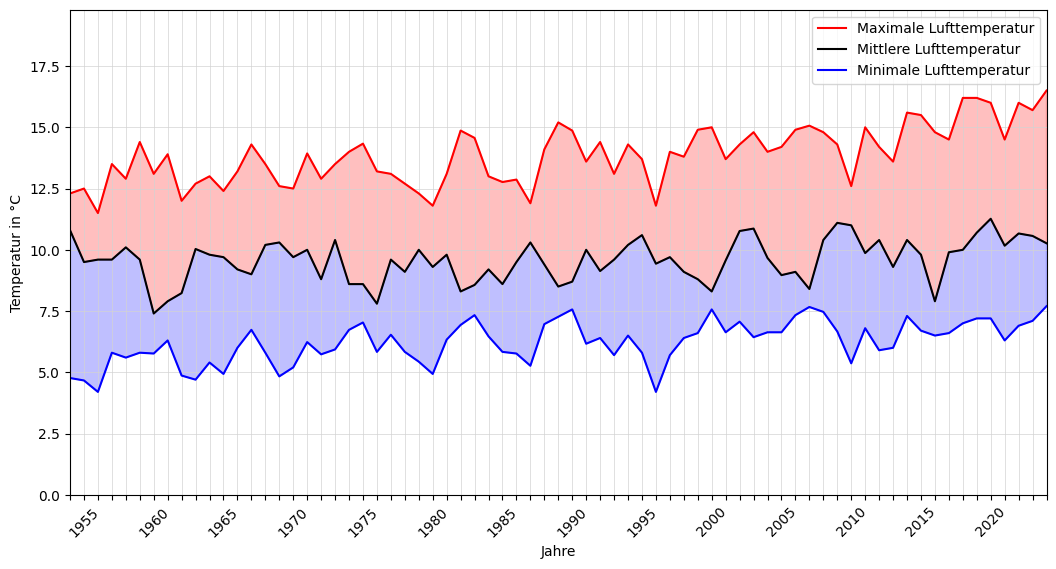

In [19]:
def plot_air_temp_min_mean_max():
    # Air Temp min mean max
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # List oft startyears
    startyears = []
    
    # Max Temp
    title, years, values_max, t_max, values_min = years_values('air_temp_max')
    t_max = [t_max[i]/10 for i in range(len(t_max))]                            # 1/10 so it is in degrees noch in degrees/10
    startyears.append(years[0])

    # Mean Temp
    title, years, values_max, t_mean, values_min = years_values('air_temp_mean')
    t_mean = [t_mean[i]/10 for i in range(len(t_mean))]
    startyears.append(years[0])

    # Min Temp
    title, years, values_max, t_min, values_min = years_values('air_temp_min')
    t_min = [t_min[i]/10 for i in range(len(t_min))]
    startyears.append(years[0])

    # Crop to the same start-year
    common_startyear = int(max(startyears))
    t_max  = [v for y, v in zip(map(int, years), t_max)  if y >= common_startyear]
    t_mean = [v for y, v in zip(map(int, years), t_mean) if y >= common_startyear]
    t_min  = [v for y, v in zip(map(int, years), t_min)  if y >= common_startyear]

    # Plot
    ax.plot(years, t_max, color='red', label='Maximale Lufttemperatur')
    ax.plot(years, t_mean, color='Black', label='Mittlere Lufttemperatur')
    ax.plot(years, t_min, color='blue', label='Minimale Lufttemperatur')

    # Fill between lines
    ax.fill_between(years, t_max, t_mean, color='red', alpha=0.25)
    ax.fill_between(years, t_mean, t_min, color='blue', alpha=0.25)

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(t_max)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Eis- und Frosttage')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Temperatur in °C')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'min_mean_max_temp'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_air_temp_min_mean_max()

Successfully created and saved plot: ice_frost_days_plot.png


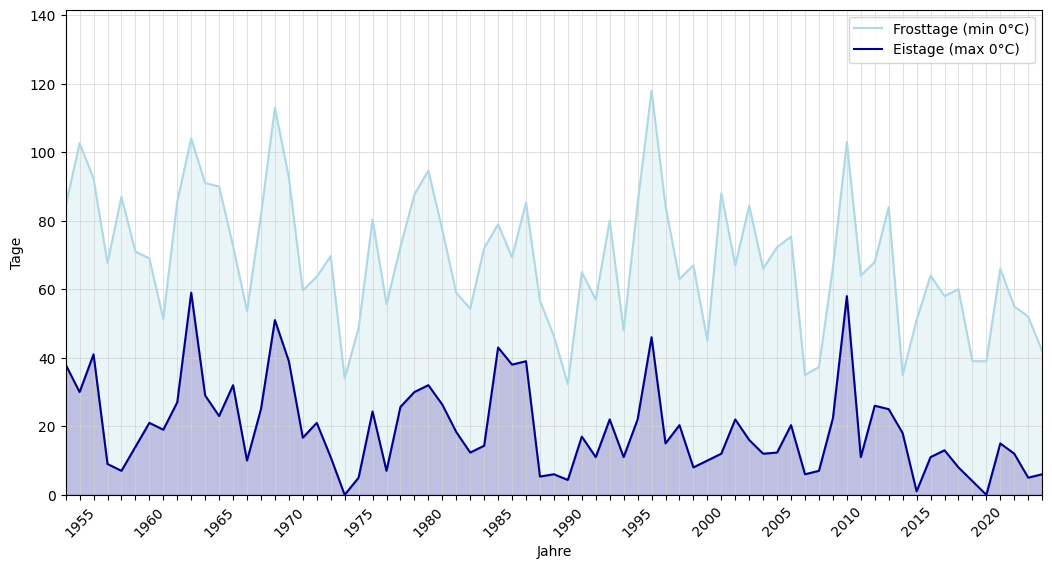

In [20]:
def plot_frost_ice_days():
    # Frost and Ice Days
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Ice Days
    title, years, values_max, values_mean_id, values_min = years_values('ice_days')

    # Frost Days
    title, years, values_max, values_mean_fd, values_min = years_values('frost_days')

    # List containing 365 (days per year) as many times as there are years (upper limit)
    days_in_year_max = [365]*len(years)

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, values_mean_fd, color='lightblue', label='Frosttage (min 0°C)')
    ax.plot(years, values_mean_id, color='darkblue', label='Eistage (max 0°C)')

    # Fill between lines
    ax.fill_between(years, values_mean_fd, values_mean_id, color='lightblue', alpha=0.25)
    ax.fill_between(years, values_mean_id, days_in_year_min, color='darkblue', alpha=0.25)

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(values_mean_fd)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Eis- und Frosttage')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'ice_frost_days'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_frost_ice_days()

Successfully created and saved plot: snowcover_days_plot.png


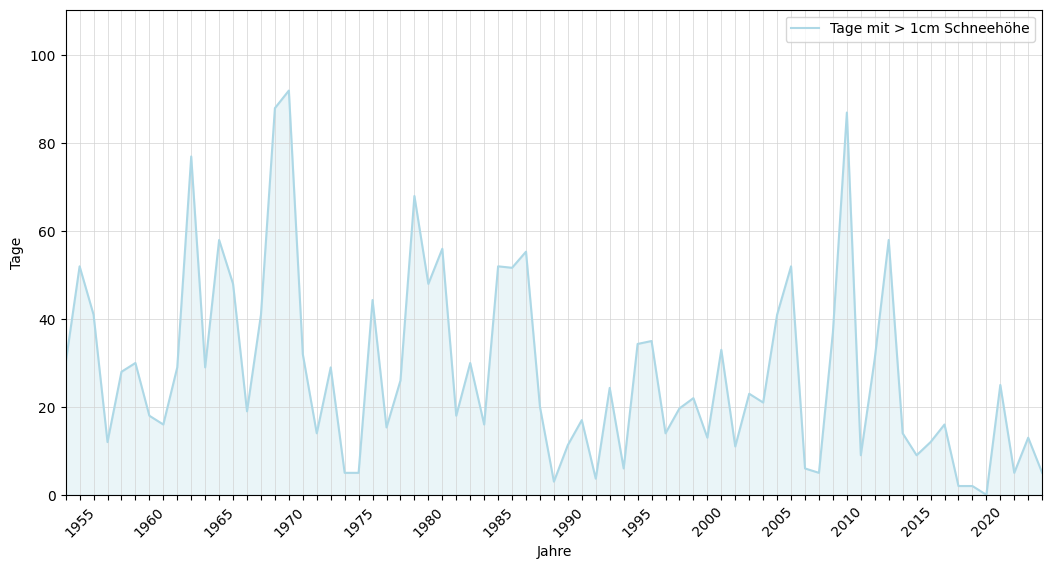

In [21]:
def plot_snowcover_days():
    # Snowcover Days
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Snowcover Days
    title, years, values_max, values_mean_snd, values_min = years_values('snowcover_days')

    # List containing 365 (days per year) as many times as there are years (upper limit)
    days_in_year_max = [365]*len(years)

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, values_mean_snd, color='lightblue', label='Tage mit > 1cm Schneehöhe')

    # Fill between lines
    ax.fill_between(years, values_mean_snd, days_in_year_min, color='lightblue', alpha=0.25)
    
    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(values_mean_snd)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Eis- und Frosttage')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'snowcover_days'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_snowcover_days()

Successfully created and saved plot: summer_hot_days_plot.png


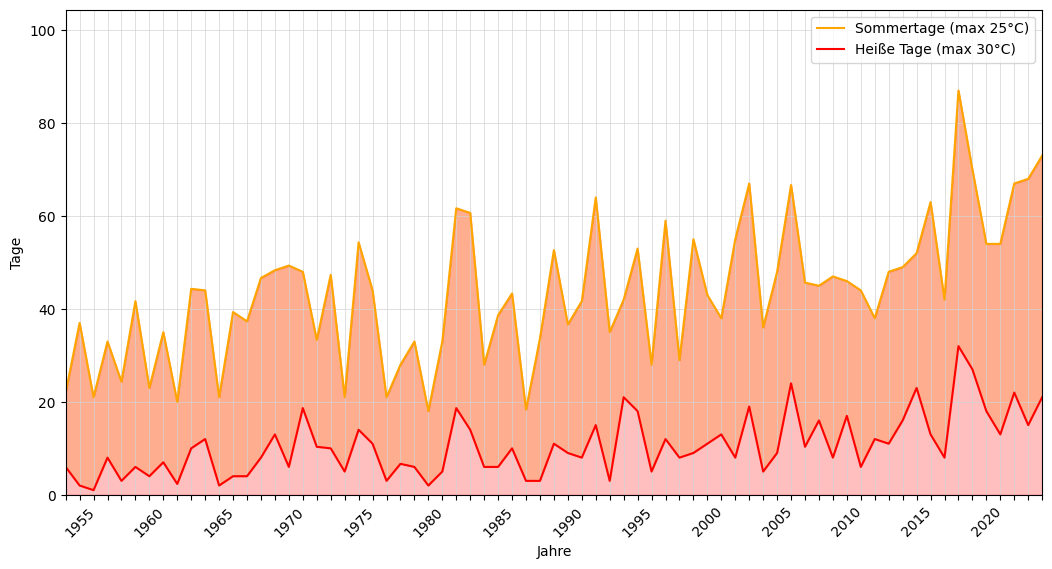

In [22]:
def plot_summer_hot_days():
    # Summer and Hot Days
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Ice Days
    title, years, values_max, values_mean_sd, values_min = years_values('summer_days')

    # Frost Days
    title, years, values_max, values_mean_hd, values_min = years_values('hot_days')

    # List containing 365 (days per year) as many times as there are years (upper limit)
    days_in_year_max = [365]*len(years)

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, values_mean_sd, color='orange', label='Sommertage (max 25°C)')
    ax.plot(years, values_mean_hd, color='red', label='Heiße Tage (max 30°C)')

    # Fill between lines
    ax.fill_between(years, values_mean_hd, values_mean_sd, color='orange', alpha=0.25)
    ax.fill_between(years, values_mean_sd, days_in_year_min, color='red', alpha=0.25)

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(values_mean_sd)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Heiße- und Sommertage')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'summer_hot_days'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_summer_hot_days()

Successfully created and saved plot: precipitation_drought_plot.png


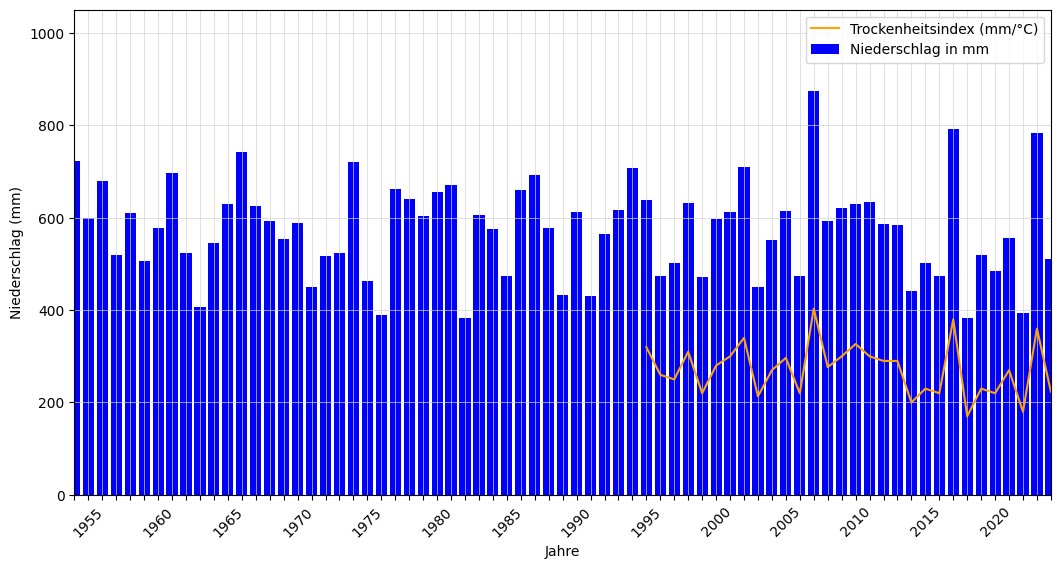

In [23]:
def plot_precipitaion():
    # Precipitation
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Precipitation
    title, years, values_max, values_mean_pp, values_min = years_values('precipitation')

    # Precipitation
    title, yearsdi, values_max, values_mean_di, values_min = years_values('drought_index')
    values_mean_di = [di*10 for di in values_mean_di]

    # Plot
    ax.bar(years, values_mean_pp, color='blue', label='Niederschlag in mm')
    ax.plot(yearsdi, values_mean_di, color='orange', label='Trockenheitsindex (mm/°C)')

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(values_mean_pp)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Niederschlag und Trockenheitsindex')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Niederschlag (mm)')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'precipitation_drought'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_precipitaion()

Successfully created and saved plot: precip_days_plot.png


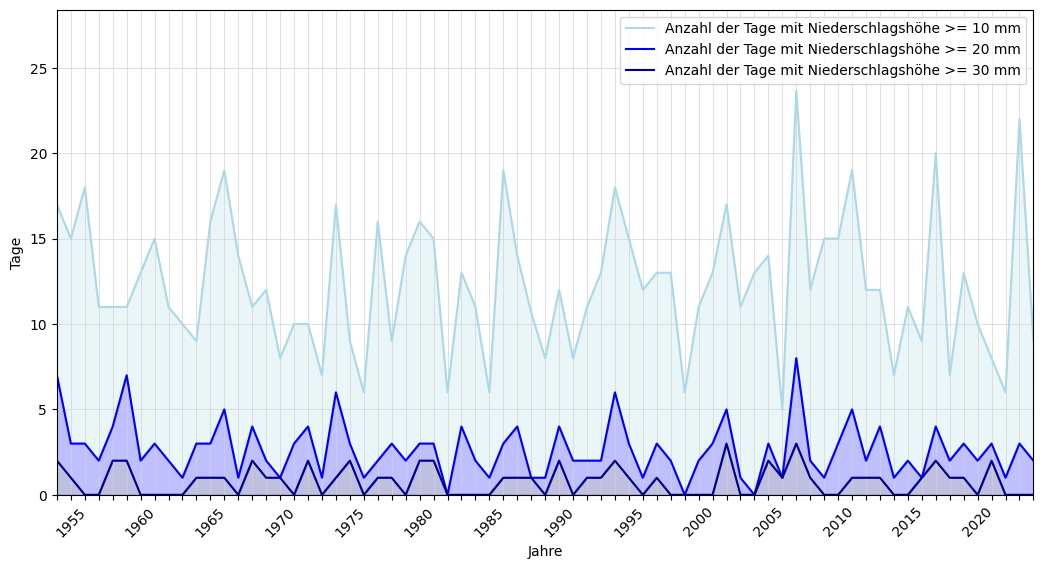

In [24]:
def plot_precipitaion_days():
    # Precipitation Days
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # 10mm
    title, years, values_max, p10, values_min = years_values('precipGE10mm_days')

    # 20mm
    title, years, values_max, p20, values_min = years_values('precipGE20mm_days')
    #p1020 = [p10[i]+p20[i] for i in range(len(p10))]

    # 30mm
    title, years, values_max, p30, values_min = years_values('precipGE30mm_days')
    #p102030 = [p10[i]+p20[i]+p30[i] for i in range(len(p10))]

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, p10, color='lightblue', label='Anzahl der Tage mit Niederschlagshöhe >= 10 mm')
    ax.plot(years, p20, color='blue', label='Anzahl der Tage mit Niederschlagshöhe >= 20 mm')
    ax.plot(years, p30, color='darkblue', label='Anzahl der Tage mit Niederschlagshöhe >= 30 mm')

    # Fill between lines
    ax.fill_between(years, p10, p20, color='lightblue', alpha=0.25)
    ax.fill_between(years, p20, p30, color='blue', alpha=0.25)
    ax.fill_between(years, p30, days_in_year_min, color='darkblue', alpha=0.25)

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(p10)*1.2])
    ax.set_xlim(['1954', max(years)])
    #ax.set_title('Anzahl der Niederschlagstage')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'precip_days'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_precipitaion_days()

Successfully created and saved plot: sunshine_duration_plot.png


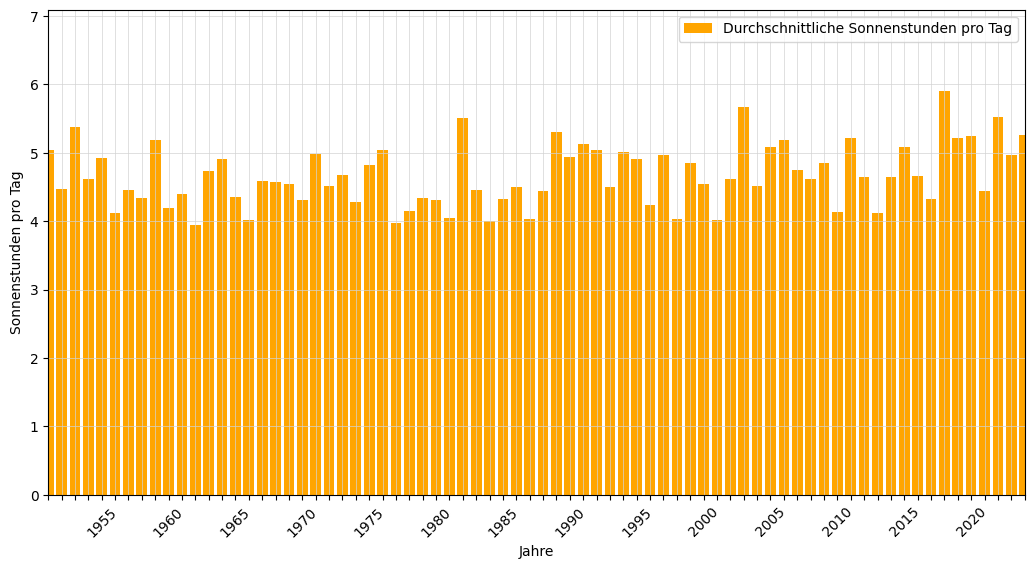

In [25]:
def plot_sunshine_duration():
    # Sunshine Duration
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Sunshine Duration
    title, years, values_max, values_mean_sd, values_min = years_values('sunshine_duration')
    values_mean_sd = [sd/365 for sd in values_mean_sd]

    # Plot
    ax.bar(years, values_mean_sd, color='orange', label='Durchschnittliche Sonnenstunden pro Tag')

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, max(values_mean_sd)*1.2])
    ax.set_xlim([min(years), max(years)])
    #ax.set_title('Niederschlag und Trockenheitsindex')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Sonnenstunden pro Tag')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'sunshine_duration'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_sunshine_duration()

Successfully created and saved plot: vegetativ_phase_plot.png


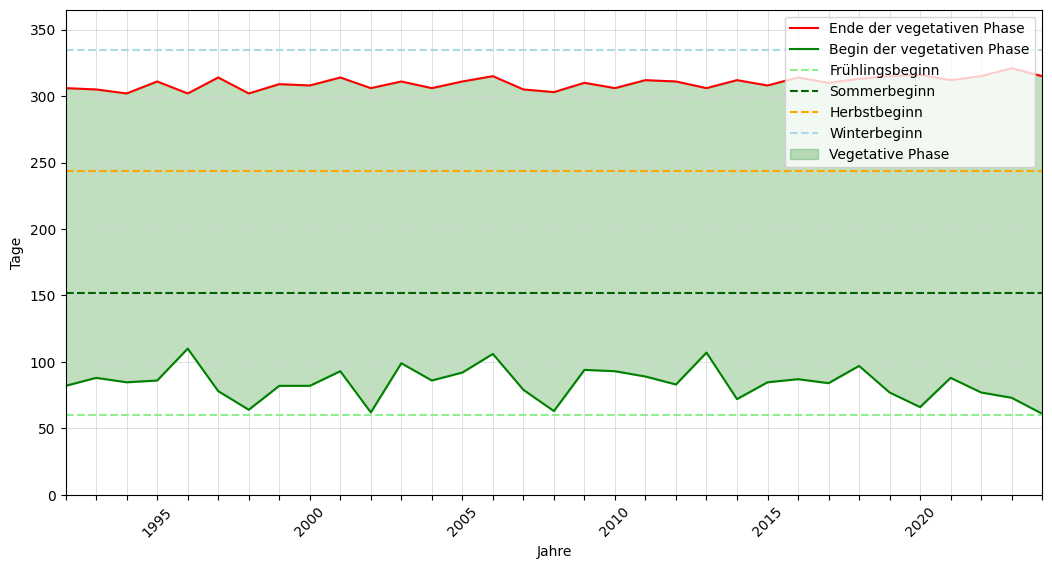

In [26]:
def plot_vegetation_begin_end():
    # Vegetation begin and vegetation end
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Vegetation begin line
    title, years, values_max, values_mean_b, values_min = years_values('vegetation_begin')

    # Vegetation end line
    title, years, values_max, values_mean_e, values_min = years_values('vegetation_end')

    # List containing 365 (days per year) as many times as there are years (upper limit)
    days_in_year_max = [365]*len(years)

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, values_mean_e, color='red', label='Ende der vegetativen Phase')
    ax.plot(years, values_mean_b, color='green', label='Begin der vegetativen Phase')
    ax.axhline(y=60, color='lightgreen', linestyle='--', label='Frühlingsbeginn')
    ax.axhline(y=152, color='darkgreen', linestyle='--', label='Sommerbeginn')
    ax.axhline(y=244, color='orange', linestyle='--', label='Herbstbeginn')
    ax.axhline(y=335, color='lightblue', linestyle='--', label='Winterbeginn')

    # Fill between lines
    ax.fill_between(years, values_mean_e, values_mean_b, color='green', alpha=0.25, label='Vegetative Phase')

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, 365])
    ax.set_xlim([min(years), max(years)])
    #ax.set_title('Vegetative Phase')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'vegetativ_phase'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_vegetation_begin_end()

Successfully created and saved plot: vegetativ_phase_len_plot.png


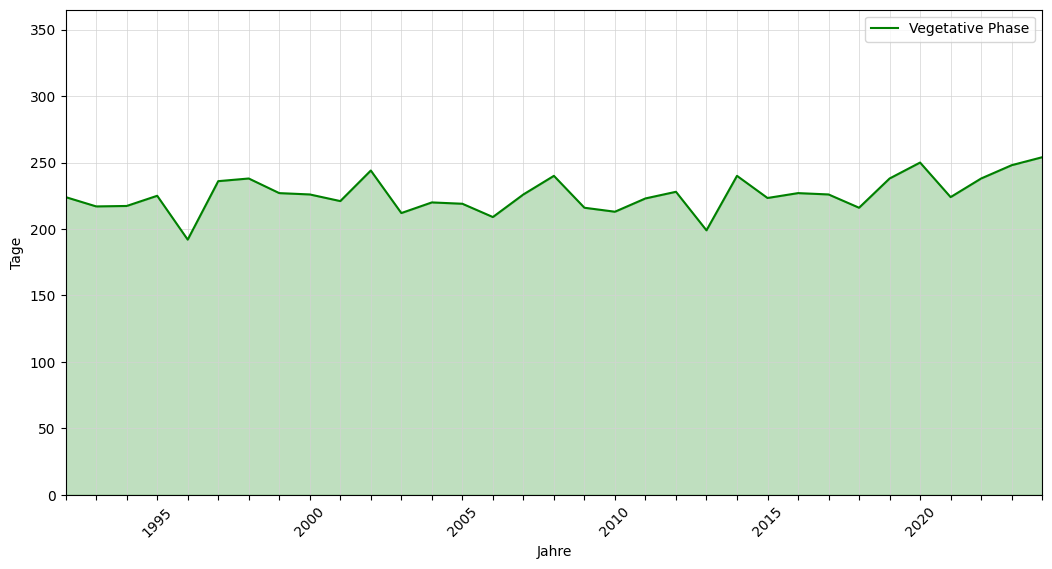

In [27]:
def plot_vegetation_phase_length():
    # Vegetation phase length
    plt.close()

    # Create a figure containing a single Axes.
    fig, ax = plt.subplots()

    # Vegetation begin line
    title, years, values_max, values_mean_b, values_min = years_values('vegetation_begin')

    # Vegetation end line
    title, years, values_max, values_mean_e, values_min = years_values('vegetation_end')

    # Vegetation phase length
    veg_len = [values_mean_e[i]-values_mean_b[i] for i in range(len(years))]

    # List containing 365 (days per year) as many times as there are years (upper limit)
    days_in_year_max = [365]*len(years)

    # List containing 365 (days per year) as many times as there are years (lower limit)
    days_in_year_min = [0]*len(years)

    # Plot
    ax.plot(years, veg_len, color='green', label='Vegetative Phase')

    # Fill between lines
    ax.fill_between(years, veg_len, days_in_year_min, color='green', alpha=0.25)

    # Gridlines:
    ax.grid(color='lightgrey', linewidth=0.5)

    # Plot Customization
    fig.set_size_inches(6.3*2, 3.15*2)
    ax.set_ylim([0, 365])
    ax.set_xlim([min(years), max(years)])
    #ax.set_title('Länge der vegetativen Phase')
    ax.set_xlabel('Jahre')
    ax.set_ylabel('Tage')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    for label in ax.xaxis.get_ticklabels():  # Iterate over all ticklabels
        if int(label.get_text()) % 5 == 0:   # Check if ticklabel is dividable by 5
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Save Plot
    plotname = 'vegetativ_phase_len'+'_plot.png'
    plot_folder_path = Path.cwd() / 'plots'
    plot_folder_path.mkdir(parents=True, exist_ok=True)
    plot_path = str(plot_folder_path / plotname)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    print(f'Successfully created and saved plot: {plotname}')
plot_vegetation_phase_length()